# 2022 SW University Deep Learning Challenge – OpenMax Implementation

This notebook implements an Open Set Recognition pipeline using OpenMax.
The core focus is applying Weibull-based score recalibration (libmr)
to detect unknown classes in a real competition environment.


In [ ]:
pip install libmr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for libmr: filename=libmr-0.1.9-cp37-cp37m-linux_x86_64.whl size=388694 sha256=979ab30e5721dd383aa3213cdff0614ad14f91fe3cb63dfc9d1bc1069b84ef13
  Stored in directory: /root/.cache/pip/wheels/b0/54/28/fadd1fd7df1f0db683e5d8e05fb06bfa65e329245ad933b534
Successfully built libmr


In [ ]:
import os
import time
import datetime
import easydict
import random
from pathlib import Path
import matplotlib.pyplot as plt
import libmr

import torch
import torchsummary
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from torch.optim import SGD, AdamW
from torch.utils.data import DataLoader

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

Using PyTorch version: 1.12.1+cu113, Device: cuda


In [ ]:
args = easydict.EasyDict({
    # device setting
    'device': 0,
    'seed' : 123,

    # training setting
    'batch_size' : 512,
    'num_workers' : 2,
    'epoch' : 15,

    # optimizer & criterion
    'lr' : 0.001,
    'momentum' : 0.9,
    'weight_decay' : 1e-4,
    'nesterov' : True,

    # directory
    'data_path' : '/content/drive/MyDrive/coding/colab/SWunivChallenge/2022swunivchallenge/dataset',
    'save_path' : '/content/drive/MyDrive/coding/colab/SWunivChallenge/2022swunivchallenge/submssion',
    # etc
    'print_freq' : 30,

})

# 데이터 로드

In [ ]:
def load_data(args, data_type:str='train'):
    """
    data_type(str): train or test
    """
    start = time.time()
    data_path = Path(args.data_path) / data_type
    features = np.load(data_path/'features.npy')
    if data_type == 'test':
        labels = np.zeros_like(features)  # dummy test label
    else:
        labels = np.load(data_path/'labels.npy')
    end = time.time()
    sec = end - start
    print(f"Completed Loading {data_type} data at {str(datetime.timedelta(seconds=sec)).split('.')[0]}")
    return features, labels

In [ ]:
# Load train_data
train_data, train_label = load_data(args, 'train')

# Load test data
test_data, test_label = load_data(args, 'test')


Completed Loading train data at 0:00:25
Completed Loading test data at 0:00:04


In [ ]:
class Dataset:
    def __init__(self, features, labels, transform=None):
        """Basic Dataset Class

        :arg
            features: numpy array(features)
            labels: numpy asrray(labels)
        """
        self.features = features
        self.labels = labels
        self.classes = np.unique(self.labels)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]

        if self.transform:
            feature = self.transform(feature)

        label = self.labels[idx]
        return feature, label

In [ ]:
train_dataset = Dataset(train_data, train_label)
test_dataset = Dataset(test_data, test_label)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

In [ ]:
class SampleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=2048, out_channels=4096, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(4096)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(in_channels=4096, out_channels=1024, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.conv3 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=1024, out_channels=4096, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(4096)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc1 = nn.Linear(4096, 80)

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)


        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)


        x = self.fc1(x)
        return x


In [ ]:
model = SampleModel().to(DEVICE)
criterion = nn.CrossEntropyLoss()
#optimizer = SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay, nesterov=args.nesterov)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                       lr_lambda=lambda epoch: 0.95 ** epoch)

In [ ]:
loss_arr =[]
for i in range(args.epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(DEVICE)
        y = label.to(DEVICE)
        optimizer.zero_grad()
        output = model.forward(x)

        loss = criterion(output,y)
        loss.backward()
        optimizer.step()

        if j % 1000 == 0:
          print(i)
          print(loss)
          loss_arr.append(loss.cpu().detach().numpy())

0
tensor(4.4165, device='cuda:0', grad_fn=<NllLossBackward0>)
1
tensor(1.7023, device='cuda:0', grad_fn=<NllLossBackward0>)
2
tensor(0.8992, device='cuda:0', grad_fn=<NllLossBackward0>)
3
tensor(0.4478, device='cuda:0', grad_fn=<NllLossBackward0>)
4
tensor(0.2523, device='cuda:0', grad_fn=<NllLossBackward0>)
5
tensor(0.2501, device='cuda:0', grad_fn=<NllLossBackward0>)
6
tensor(0.2142, device='cuda:0', grad_fn=<NllLossBackward0>)
7
tensor(0.1490, device='cuda:0', grad_fn=<NllLossBackward0>)
8
tensor(0.1066, device='cuda:0', grad_fn=<NllLossBackward0>)
9
tensor(0.0670, device='cuda:0', grad_fn=<NllLossBackward0>)
10
tensor(0.1001, device='cuda:0', grad_fn=<NllLossBackward0>)
11
tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward0>)
12
tensor(0.0382, device='cuda:0', grad_fn=<NllLossBackward0>)
13
tensor(0.0196, device='cuda:0', grad_fn=<NllLossBackward0>)
14
tensor(0.0434, device='cuda:0', grad_fn=<NllLossBackward0>)


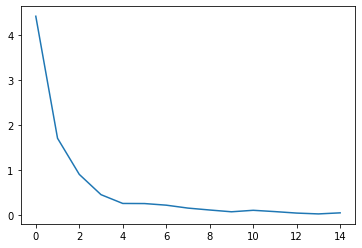

In [ ]:
plt.plot(loss_arr)
plt.show()

In [ ]:
pred_scores = []

for x,y in train_loader:
  x = x.to(args.device)
  y = y.to(args.device)
  model_outputs = model(x)
  pred_scores.append(model_outputs.detach().cpu().numpy())

pred_scores = np.concatenate(pred_scores, axis=0)
train_pred_simple = np.argmax(pred_scores, axis=1)

In [ ]:
print(accuracy_score(train_label, train_pred_simple))

0.996625


In [ ]:
train_correct_actvec = pred_scores[np.where(train_label == train_pred_simple)[0]]
train_correct_labels = train_label[np.where(train_label == train_pred_simple)[0]]

In [ ]:
dist_to_means = []
mr_models, class_means = [], []
eta = 20

In [ ]:
for c in np.unique(train_label):
    class_act_vec = train_correct_actvec[np.where(train_correct_labels == c)[0], :]
    class_mean = class_act_vec.mean(axis=0)
    dist_to_mean = np.square(class_act_vec - class_mean).sum(axis=1)
    dist_to_mean = np.sort(dist_to_mean).astype(np.float64)
    dist_to_means.append(dist_to_mean)

    mr = libmr.MR()
    mr.fit_high(dist_to_mean[-eta:], eta)

    class_means.append(class_mean)
    mr_models.append(mr)

class_means = np.array(class_means)


In [ ]:
def compute_openmax(actvec):
    dist_to_mean = np.square(actvec - class_means).sum(axis=1).astype(np.float64)
    scores = []
    for dist, mr in zip(dist_to_mean, mr_models):
        scores.append(mr.w_score(dist))
    scores = np.array(scores)
    w = 1 - scores
    rev_actvec = np.concatenate([
        w * actvec,
        [((1 - w) * actvec).sum()]])
    return np.exp(rev_actvec) / np.exp(rev_actvec).sum()

def make_prediction(_scores, _T, thresholding=True):
    _scores = np.array([compute_openmax(x) for x in _scores])
    if thresholding:
        uncertain_idx = np.where(np.max(_scores, axis=1) < _T)[0]
        uncertain_vec = np.zeros((len(uncertain_idx), 80 + 1))
        uncertain_vec[:, -1] = 1
        _scores[uncertain_idx] = uncertain_vec
    _labels = np.argmax(_scores, 1)
    return _labels

def make_prediction2(_scores, _T, thresholding=True):
    _scores = F.softmax(_scores)
    _scores = _scores.numpy()
    _scores = np.concatenate([_scores, np.expand_dims(np.zeros(len(_scores)), axis=1)], axis=1)

    if thresholding:
        uncertain_idx = np.where(np.max(_scores, axis=1) < _T)[0]
        uncertain_vec = np.zeros((len(uncertain_idx), 80 + 1))
        uncertain_vec[:, -1] = 1
        _scores[uncertain_idx] = uncertain_vec
    _labels = np.argmax(_scores, 1)
    return _labels


In [ ]:
thresholding = True
threshold = 0.7
test_pred_scores = []

for x,y in test_loader:
  x = x.to(args.device)
  y = y.to(args.device)
  model_outputs = model(x)
  test_pred_scores.append(model_outputs.detach().cpu().numpy())


test_pred_scores = np.concatenate(test_pred_scores, axis=0)
#test_pred_labels = make_prediction(test_pred_scores, threshold, thresholding)
test_pred_labels = make_prediction2(torch.from_numpy(test_pred_scores), threshold, thresholding)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
test_pred_labels = np.where(test_pred_labels == 80, -1, test_pred_labels)

In [ ]:
test_pred_labels

array([13, 41, 34, 70, 44, 74, -1, -1, 68, 71, -1, -1,  4, -1, -1, 27, -1,
        9, 76,  3,  8,  3, 71, -1, -1, 34, 62, 50, 65,  0, -1,  3, -1, -1,
       63, 49, -1, 78, 60, 16, 60,  8, 74, -1, 15, 32, -1, 41, -1, 16,  3,
       45, -1, 34, -1, 12, 26, 34,  1, -1, -1, -1, -1, 44, 19, 39, 20,  3,
       -1, 79, 74, 28, 73, 31,  2, -1, 19, -1, 24, 19, 49, 75, 34, 27, 66,
       67, 26, 26, 46, 55, 34, 57, -1, -1, 53, 60, 41, -1, 18,  7, -1,  1,
       -1, 63, 18, 67, 65, 51, 50, 78, -1, 45, 77,  8, -1, -1, 59, 13,  1,
       46, 39, -1,  7, 10, -1,  2, 63, 41, -1, 63, 28, 75, 78, 59, 20, 27,
       28, -1, -1, 37, -1, -1, 27, 71,  4, 65, -1, 37, 17, 65, 16, -1, -1,
       -1, 18, -1,  3, 58, 78, 42, 79, 45, 27, -1, -1, 57, 27, -1, 35, -1,
       54, -1, 17, -1, 35, 51, 42,  0, 61, 65, 51, 46, 67, 75, 27, 13, 75,
       10, 21, 55, 23, 42, 18, 28, -1, -1, 50, -1, -1, 25, 15, 59, -1,  7,
       11, -1, 28, 71, 50, 59, -1, -1, 50, -1, 76, -1, 39, 15, -1, 68, 65,
       -1, 31, 61,  9, 22

In [ ]:
def prediction_submission(predict, args):
    """
    테스트 데이터의 idx와 예측한 prediction label을 submission.csv로 저장
    """
    submission = [[idx, label] for idx, label in enumerate(predict)]
    df = pd.DataFrame(data=submission, columns=['id_idx', 'label'], index=None)
    args.save_path = Path(args.save_path)
    args.save_path.mkdir(exist_ok=True)
    df.to_csv(args.save_path / 'submission.csv', index=False)

In [ ]:
prediction_submission(test_pred_labels, args)